In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde

In [2]:
colnames = ['ra', 'dec', 'sep', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pi', 'piErr', 
            'pmra', 'pmraErr', 'pmdec', 'pmdecErr', 'DmedGeo', 'DloGeo', 'DhiGeo', 'DmedPho', 'DloPho', 'DhiPho', 
            'BPmag', 'BPeI', 'RPmag', 'RPeI', 'BRef']
 
## this file can be downloaded from (note .gz):
## http://faculty.washington.edu/ivezic/gaia/
dataFile = '/Users/ivezic/Work/Science/Gaia/EDR3/Data/Stripe82_GaiaEDR3_CBJdistances.dat'
gaia = Table.read(dataFile, format='ascii', names=colnames)

In [3]:
len(gaia) 

843342

In [4]:
# clean entries with NaN
has_nan = np.zeros(len(gaia), dtype=bool)
for col in gaia.itercols():
    if col.info.dtype.kind == 'f':
        has_nan |= np.isnan(col)
gaiaOK = gaia[~has_nan]

In [5]:
len(gaiaOK)

842840

Make a few sanity plots to ensure all is kosher...

In [6]:
# make more sanity plots 
def makeStripe82GaiaDR3plots(Stripe82data):
    """Make a six-panel plot illustrating Gaia DR3 data for SDSS Stripe82"""

    ra = Stripe82data['ra']
    dec = Stripe82data['dec']
    nobs = Stripe82data['nObs']
    Gmag = Stripe82data['Gmag']
    flux = Stripe82data['flux']
    fluxErr = Stripe82data['fluxErr']
    pmSNR = Stripe82data['pi']/Stripe82data['piErr']

    # user wrapped RA to avoid disjoint regions 
    raW = np.where(ra > 180, ra-360, ra)
     
    ### PLOTTING ###
    plot_kwargs = dict(color='k', linestyle='none', marker='.', markersize=1)
    plt.subplots_adjust(bottom=0.15, top=0.9, left=0.15, right=0.98, wspace=0.4, hspace=0.4)

    hist, bins = np.histogram(dec, bins=50)
    center = (bins[:-1]+bins[1:])/2
    ax2 = plt.subplot(3,1,1)
    ax2.plot(center, hist, drawstyle='steps')   
    ax2.set_xlim(-1.3, 1.3)
    # ax2.set_ylim(0, 20000)
    ax2.set_xlabel(r'$\mathrm{Dec (deg)}$')
    ax2.set_ylabel(r'$\mathrm{dN/dDec}$')

    hist, bins = np.histogram(Gmag, bins=50)
    center = (bins[:-1]+bins[1:])/2
    ax3 = plt.subplot(3,1,2)
    ax3.plot(center, hist, drawstyle='steps')   
    ax3.set_xlim(12, 22)
    ax3.set_xlabel(r'$\mathrm{Gmag}$')
    ax3.set_ylabel(r'$\mathrm{dN/dGmag}$')
    
    hist, bins = np.histogram(pmSNR, bins=300)
    center = (bins[:-1]+bins[1:])/2
    ax3 = plt.subplot(3,1,3)
    ax3.plot(center, hist, drawstyle='steps')   
    ax3.set_xlim(-10, 20)
    ax3.set_xlabel(r'$\mathrm{\pi SNR}$')
    ax3.set_ylabel(r'$\mathrm{dN/d\pi}$')
    
    # save
    plt.savefig('Stripe82GaiaDR3plots1.png')
    plt.show() 

    return 

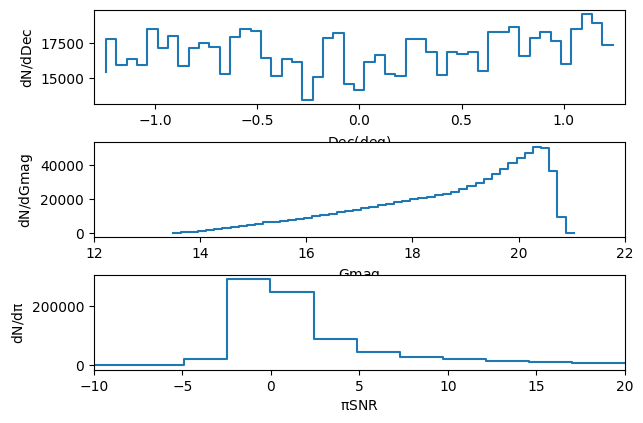

In [7]:
makeStripe82GaiaDR3plots(gaiaOK)

In [8]:
def plot2Dmap(x, y, xMin, xMax, nXbin, yMin, yMax, nYbin, xLabel, yLabel, logScale=False):

    data = np.vstack([x, y])
    kde = gaussian_kde(data)

    # evaluate on a regular grid
    xgrid = np.linspace(xMin, xMax, nXbin)
    ygrid = np.linspace(yMin, yMax, nYbin)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    # plot the result as an image
    if (logScale):
        plt.imshow(Z.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[xMin, xMax, yMin, yMax],
               cmap='Blues', 
               norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
        cb = plt.colorbar()
        cb.set_label("density on log scale")
    else: 
        plt.imshow(Z.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[xMin, xMax, yMin, yMax],
               cmap='Blues') 
        cb = plt.colorbar()
        cb.set_label("density on lin scale")

    plt.xlabel(xLabel)
    plt.ylabel(yLabel)

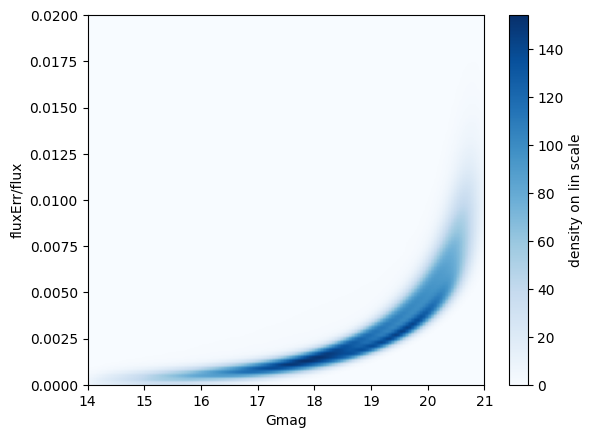

In [9]:
flux = gaiaOK['flux']
fluxErr = gaiaOK['fluxErr']
relFerr = fluxErr/flux 
Gmag = gaiaOK['Gmag'] 
plot2Dmap(Gmag, relFerr, 14, 21, 140, 0, 0.02, 100, 'Gmag', 'fluxErr/flux')

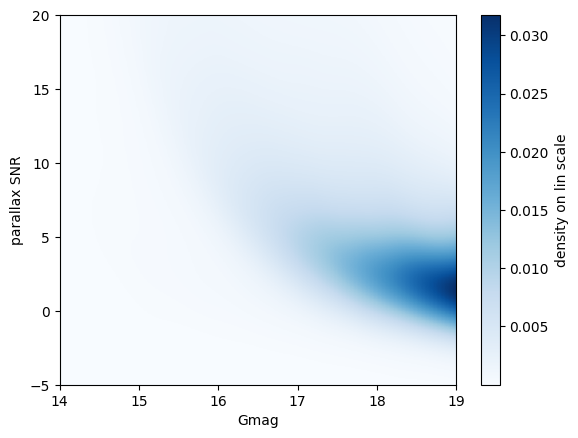

In [10]:
pmSNR = gaiaOK['pi'] / gaiaOK['piErr']
plot2Dmap(Gmag, pmSNR, 14, 19, 100, -5, 20, 250, 'Gmag', 'parallax SNR')

In [11]:
colnames = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

## this file (non-variable calibration stars) and info about it can be downloaded from:
## http://faculty.washington.edu/ivezic/sdss/catalogs/stripe82.html
## or directly as
## http://faculty.washington.edu/ivezic/sdss/calib82/dataV2/stripe82calibStars_v4.2.dat
sdss = Table.read('../Data/stripe82calibStars_v4.2.dat', format='ascii', names=colnames)

Match Gaia to SDSS, since here SDSS is much larger 

In [12]:
sdss_coords = SkyCoord(ra = sdss['ra']*u.degree, dec= sdss['dec']*u.degree) 
gaia_coords = SkyCoord(ra = gaiaOK['ra']*u.degree, dec= gaiaOK['dec']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idx, d2d, d3d = gaia_coords.match_to_catalog_sky(sdss_coords)  

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
gaia_sdss = hstack([gaiaOK, sdss[idx]], table_names = ['gaia', 'sdss'])
gaia_sdss['sep_2d_arcsec'] = d2d.arcsec

# since it's matching gaia to sdss,
# the resulting catalog has the same length 
# as gaia ... 

In [13]:
dra = 3600*(gaia_sdss['ra_sdss'] - gaia_sdss['ra_gaia']) 
ddec = 3600*(gaia_sdss['dec_sdss'] - gaia_sdss['dec_gaia'])  

### Select good matches

In [14]:
# gaia sources that have a good sdss match 
flag = (gaia_sdss['sep_2d_arcsec'] < 0.5)   
gaia_matched = gaia_sdss[flag]
print(len(gaia_sdss))
print(len(gaia_matched))

842840
820880


## Coryn Bailer-Jones et al. distances

In [26]:
gaia_matched['DMpho'] = 5*np.log10(gaia_matched['DmedPho']/10)
gaia_matched['MrPho'] = gaia_matched['r_mMed'] - gaia_matched['DMpho']

In [32]:
rMed = gaia_matched['r_mMed'] 
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']

# new for EDR3
flagOK = ((rMed>14) & (rMed<21) & (gi>-1.0) & (gi<4.0))
gaia_matchedOK = gaia_matched[flagOK]
print(len(gaia_matchedOK))

772416


In [37]:
## bright subset  
gaiaBright = gaia_matchedOK[gaia_matchedOK['r_mMed']<20]

In [28]:
## SDSS Mr vs. g-i relation from Ivezic et al. (2008)
def getMr(gi, FeH):
    MrFit = -5.06 + 14.32*gi -12.97*gi**2 + 6.127*gi**3 -1.267*gi**4 + 0.0967*gi**5
    ## offset for metallicity, valid for -2.5 < FeH < 0.2
    FeHoffset = 4.50 -1.11*FeH -0.18*FeH**2
    return MrFit + FeHoffset

In [38]:
# for plotting color-magnitude diagram
gi = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed']
Mr = gaia_matchedOK['MrPho']
# bright: 
giB = gaiaBright['g_mMed'] - gaiaBright['i_mMed']
MrB = gaiaBright['MrPho']

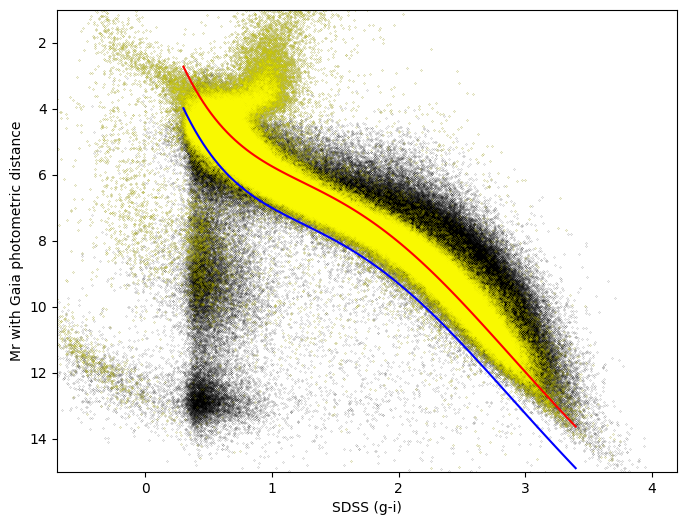

In [39]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gi, Mr, s=0.01, c='black')
ax.scatter(giB, MrB, s=0.01, c='yellow')
ax.set_xlim(-0.7,4.2)
ax.set_ylim(15,1.0)
ax.set_xlabel('SDSS (g-i)')
ax.set_ylabel('Mr with Gaia photometric distance')

# add SDSS photometric parallax relation for comparison 
giGrid = np.linspace(0.3, 3.4, 100)
FeH = 0       ## disk metallicity
MrPP = getMr(giGrid, FeH)
ax.plot(giGrid, MrPP, c='red')
FeH = -1.5    ## halo metallicity
MrPP = getMr(giGrid, FeH)
ax.plot(giGrid, MrPP, c='blue')